<a href="https://colab.research.google.com/github/hrishipoola/Detecting_Treating_Wine_Price_Outliers/blob/main/Detecting_%26_Treating_Price_Outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Detecting & Treating Price Outliers

## Table of Contents

1. Introduction
2. Install & Import Packages
3. Load & Process Data
4. Detect 
<br> Plot
<br> Tukey's Method
<br> Median Absolute Deviation (MAD)
5. Treat 
<br> Winsorize
<br> Impute
6. References

## 1. Introduction

A few outliers can significantly skew our understanding of variables or influence a predictive model. Depending on the source and nature of the outliers, they could also hold valuable information. Detecting and treating them needs special care. Here's a clear, thorough, and useful series of posts on outliers ([Part 1](https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-1-4ece5098b755), [Part 2](https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33), [Part 3](https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-3-dcb54abaf7b0)). Here's a great paper on best practices by [Aguinis et al](http://www.hermanaguinis.com/ORMoutliers.pdf). 

Today, let's work with Mike Powell's [global wine data set](https://data.world/markpowell/global-wine-points) that includes vintage, country, county, designation, province, title, variety, winery, points, and price per bottle for nearly 25,000 wines. Let's say a global winery's marketing team would like to understand and model wine points using price as a variable. Extreme price values could unduly influence the model so let's understand, detect, and handle them. 

#### **Univariate or Multivariate**

First let's check if outliers are univariate or multivariate. Univariate outliers are extreme values in the distribution of a specific variable, for example, a \$5,000 bottle. Multivariate outliers are unlikely combinations of values, for example, a \$5,000 bottle of a 2018 vintage with a low score of 83 points. For simplicity, let's focus on univariate price outliers here. If you're interested in multivariate outliers, check out applications of [Mahalanoubis distance](https://www.machinelearningplus.com/statistics/mahalanobis-distance/) and [minimum covariance distance](https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33). 

#### **Source**

Next, let's understand the source of the outliers to see how we'd like to treat them. In our case, price outliers aren't due to human or measurement error, but are true extreme values not fully representative of the wine population. We don't want to keep them as is, but, since they hold valuable information, we don't want to simply delete them. Instead, we can recode them to moderate their impact. 

#### **Detect**

Let's plot distribution of key variables to understand them a bit more. For example, we'll see that price is heavily right-skewed, while vintage is heavily left-skewed. 

To detect outliers, we'll use 2 approaches - Tukey's method and Median Absolute Deviation (MAD). We avoid using the z-score method (studentized residuals) because:

- Distribution mean and standard deviation are sensitive to outliers  - Finding an outlier is dependent on other outliers as every observation affects the mean
- It assumes variable is normally distributed 

Externally studentized residuals removes the influence of each observation from the calculation, but the distribution is still sensitive to outliers and it assumes the variable is normally distributed. 


##### **Tukey's Method**

Tukey's method generates possible and probable outliers by constructing inner and outer fences based on IQR. The lower inner fence is 1.5 x IQR below Q1, while the upper inner fence is 1.5 x IQR above Q3. The lower outer fence is 3 x IQR below Q1, while the upper outer fence is 3 x IQR above Q3. Possible outliers lie between the inner and outer fence, while probable outliers lie outside the outer fence. We care about treating the probable outliers. Tukey's method is robust to outliers and doesn't require a normal distribution. Additionally, for right-skewed data, we can still apply Tukey's method on log transformed variables. 

##### **MAD**

MAD is a modified, more robust alternative to z-score. It replaces mean and standard deviation with median and median absolution deviation and is more robust to outliers and doesn't assume the variable is normally distributed. Outliers lie beyond the cutoff of 3. 

#### **Treat**

##### **Winsorize**

Winsorizing replaces all values beyond a k percentile with the k percentile value, which is less extreme than simply removing these values. Piggybacking off of the Tukey method, the k percentile will be set at the distribution's outer fence. 

The price variable's upper outer fence is 117, which is closest to the 97.5% (109), so let's set the upper bound for winsorization to 97.5%. For the lower bound, a price below zero doesn't make sense, so we'll set the lower bound to 0 and the data will only be right-tail winsorized.  


##### **Impute**

Similar to howe we've imputed missing values in previous posts, we can apply it to outliers by replacing outliers with NaN and imputing these new missing values with estimates based on the remaining data. Rather than simple imputation with mean or median, which obscures valuable information held by extreme values, let's apply iterative imputation. 

In sklearn's IterativeImputer, the outlier becomes a dependent variable in a prediction model and is predicted based on remaining non-missing non-outlier values. The default estimator is regularized linear regression BayesianRidge. Let's impute both Tukey's probable outliers and MAD outliers. 

Finally, we'll bring it all together with a statistical summary to compare how the mean and max of the original price compares to log price, winsorized, imputed Tukey's, and imputed MAD. 




## 2. Install & Import Packages

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date, timedelta
from scipy import stats
from scipy.stats.mstats import winsorize

from sklearn.experimental import enable_iterative_imputer  # since experimental API, need to enable first 
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import make_pipeline
import random
random.seed(1111)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
sns.set_style("darkgrid")
style.use('fivethirtyeight')

import io
from io import BytesIO
from zipfile import ZipFile

## 3. Load & Process Data

In [ ]:
# Mount google drive
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Wines.xlsx to Wines.xlsx


In [ ]:
wines_raw = pd.read_excel(io.BytesIO(uploaded['Wines.xlsx']))
wines_raw.head()

,Vintage,Country,County,Designation,Points,Price,Province,Title,Variety,Winery
0,1919-01-01 00:00:00,Spain,Cava,1919 Brut Selecció,88,$13.00,Catalonia,L'Arboc NV 1919 Brut Selecció Sparkling (Cava),Sparkling Blend,L'Arboc
1,1929-01-01 00:00:00,Italy,Vernaccia di San Gimignano,NaN,87,$14.00,Tuscany,Guidi 1929 2015 Vernaccia di San Gimignano,Vernaccia,Guidi 1929
2,1929-01-01 00:00:00,Italy,Sangiovese di Romagna Superiore,Prugneto,84,$15.00,Central Italy,Poderi dal Nespoli 1929 2011 Prugneto (Sangiov...,Sangiovese,Poderi dal Nespoli 1929
3,1934-01-01 00:00:00,Portugal,NaN,Reserva Velho,93,$495.00,Colares,Adega Viuva Gomes 1934 Reserva Velho Red (Cola...,Ramisco,Adega Viuva Gomes
4,1945-01-01 00:00:00,France,Rivesaltes,Legend Vintage,95,$350.00,Languedoc-Roussillon,Gérard Bertrand 1945 Legend Vintage Red (Rives...,Red Blend,Gérard Bertrand


In [ ]:
def format_wines(df_raw):
  global wines
  wines = df_raw.filter(['Vintage', 'Country', 'Designation', 'Points', 'Price', 'Province','Title','Variety','Winery'])
  wines.Vintage = pd.to_datetime(df_raw.Vintage)
  wines.Vintage = wines.Vintage.dt.year
  wines.Designation.fillna('None', inplace=True)
  wines.Price = wines.Price.str.replace('[^\d\.]', '').astype(float) # replace non-numeric or non-decimal point, float type
  wines.drop_duplicates(subset=['Title','Points'], keep=False, inplace=True)
  wines.dropna(inplace=True)
  wines['Value'] = wines['Points'] / wines['Price'] # Create 'Value' variable that's a ratio of points to price
  return wines

format_wines(wines_raw)
wines.head()

,Vintage,Country,Designation,Points,Price,Province,Title,Variety,Winery,Value
0,1919,Spain,1919 Brut Selecció,88,13.0,Catalonia,L'Arboc NV 1919 Brut Selecció Sparkling (Cava),Sparkling Blend,L'Arboc,6.769231
1,1929,Italy,None,87,14.0,Tuscany,Guidi 1929 2015 Vernaccia di San Gimignano,Vernaccia,Guidi 1929,6.214286
2,1929,Italy,Prugneto,84,15.0,Central Italy,Poderi dal Nespoli 1929 2011 Prugneto (Sangiov...,Sangiovese,Poderi dal Nespoli 1929,5.600000
3,1934,Portugal,Reserva Velho,93,495.0,Colares,Adega Viuva Gomes 1934 Reserva Velho Red (Cola...,Ramisco,Adega Viuva Gomes,0.187879
4,1945,France,Legend Vintage,95,350.0,Languedoc-Roussillon,Gérard Bertrand 1945 Legend Vintage Red (Rives...,Red Blend,Gérard Bertrand,0.271429


In [ ]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22585 entries, 0 to 24995
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Vintage      22585 non-null  int64  
 1   Country      22585 non-null  object 
 2   Designation  22585 non-null  object 
 3   Points       22585 non-null  int64  
 4   Price        22585 non-null  float64
 5   Province     22585 non-null  object 
 6   Title        22585 non-null  object 
 7   Variety      22585 non-null  object 
 8   Winery       22585 non-null  object 
 9   Value        22585 non-null  float64
dtypes: float64(2), int64(2), object(6)
memory usage: 1.9+ MB


## 4. Detect

In [ ]:
wines.describe()

,Vintage,Points,Price,Value
count,22585.000000,22585.000000,22585.000000,22585.000000
mean,2010.639982,88.448085,35.585787,3.832346
std,4.223298,3.061576,41.356674,2.209974
min,1821.000000,80.000000,4.000000,0.038400
25%,2009.000000,86.000000,17.000000,2.116279
50%,2011.000000,88.000000,25.000000,3.440000
75%,2013.000000,91.000000,42.000000,5.117647
max,2016.000000,100.000000,2500.000000,21.000000


Text(0.5, 0, '$')

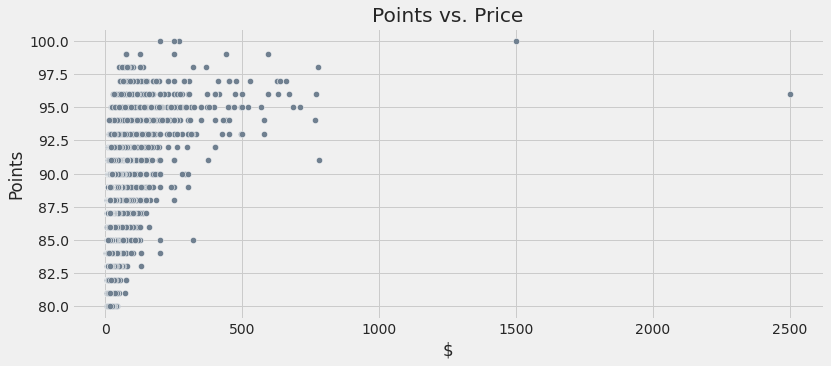

In [ ]:
plt.figure(figsize=(12,5))
sns.scatterplot(x='Price', y='Points', data=wines, color='slategray', s=40)
plt.title('Points vs. Price')
plt.xlabel('$')

Text(0.5, 0, 'Points to Price Ratio')

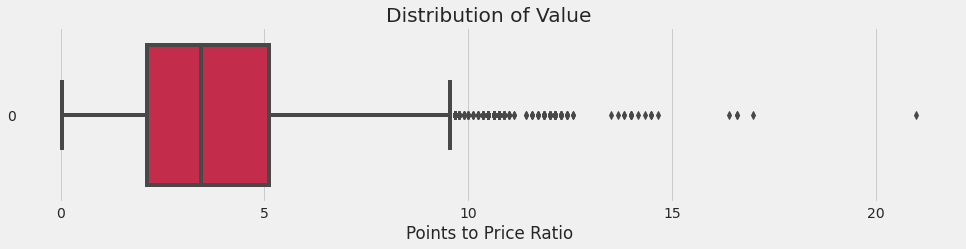

In [ ]:
plt.figure(figsize=(15,3))
sns.boxplot(data=wines['Value'], orient='h', color='crimson')
plt.title('Distribution of Value')
plt.xlabel('Points to Price Ratio')

Text(0.5, 11.11999999999999, 'Points to Price Ratio')

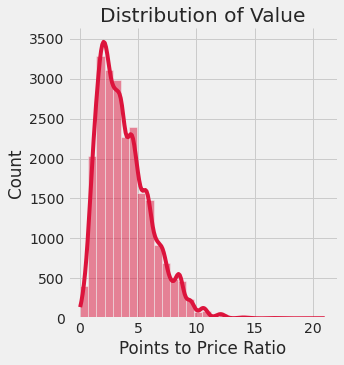

In [ ]:
# Plot distribution
sns.displot(wines['Value'],bins=30, kde=True, color='crimson')
plt.title('Distribution of Value')
plt.xlabel('Points to Price Ratio')

Text(0.5, 0, '$')

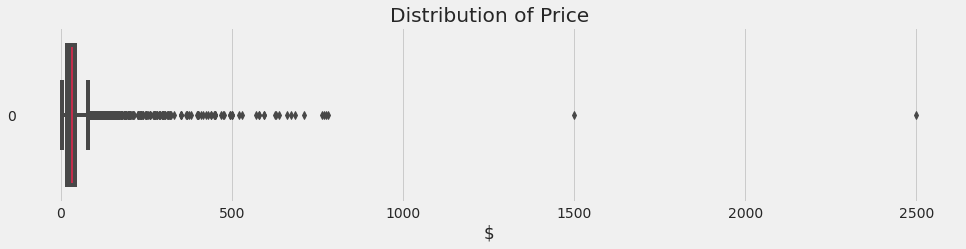

In [ ]:
plt.figure(figsize=(15,3))
sns.boxplot(data=wines['Price'], orient='h', color='crimson')
plt.title('Distribution of Price')
plt.xlabel('$')

Text(0.5, 11.11999999999999, '$')

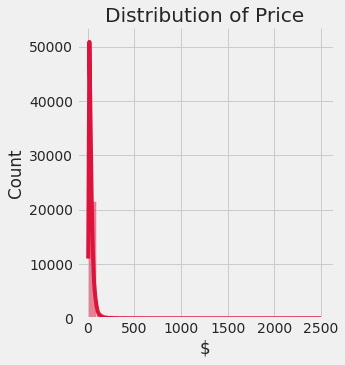

In [ ]:
# Plot distribution
sns.displot(wines['Price'],bins=30, kde=True, color='crimson')
plt.title('Distribution of Price')
plt.xlabel('$')

Text(0.5, 0, 'Year')

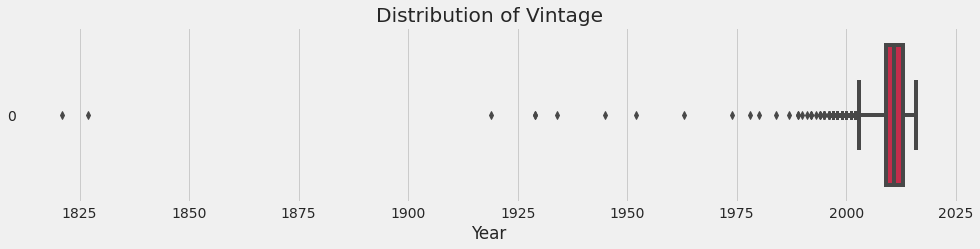

In [ ]:
plt.figure(figsize=(15,3))
sns.boxplot(data=wines['Vintage'], orient='h', color='crimson')
plt.title('Distribution of Vintage')
plt.xlabel('Year')

Text(0.5, 11.11999999999999, 'Year')

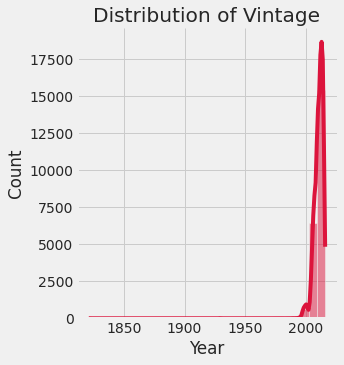

In [ ]:
# Plot distribution
sns.displot(wines['Vintage'],bins=30, kde=True, color='crimson')
plt.title('Distribution of Vintage')
plt.xlabel('Year')

Out of curiousity, I did a quick plot of the top 10 value (points to price ratio) wines. 

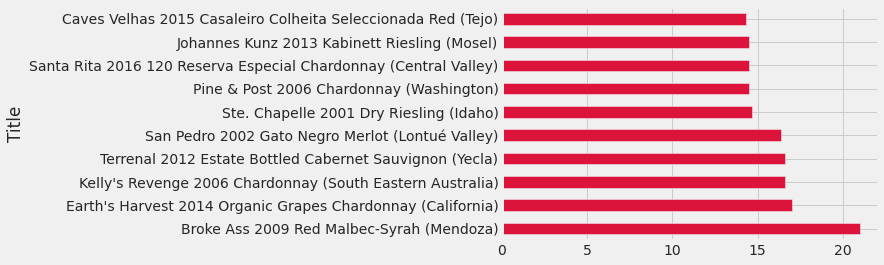

In [ ]:
wines.groupby('Title')['Value'].mean().sort_values(ascending=False)[:10].plot(kind='barh', color='crimson')

### Tukey's Method

Tukey's method generates possible and probable outliers by constructing inner and outer fences based on IQR. The lower inner fence is 1.5 x IQR below Q1, while the upper inner fence is 1.5 x IQR above Q3. The lower outer fence is 3 x IQR below Q1, while the upper outer fence is 3 x IQR above Q3. Possible outliers lie between the inner and outer fence, while probable outliers lie outside the outer fence. We care about treating the probable outliers. Tukey's method is robust to outliers and doesn't require a normal distribution. Additionally, for right-skewed data, we can still apply Tukey's method on log transformed variables. 

In [ ]:
def tukeys_method(df, variable):
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1 - inner_fence
    inner_fence_ue = q3 + inner_fence
    
    #outer fence lower and upper end
    outer_fence_le = q1 - outer_fence
    outer_fence_ue = q3 + outer_fence
    
    outliers_probable = []
    outliers_possible = []
    for index, x in enumerate(df[variable]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_probable.append(index)
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_possible.append(index)
    return outliers_probable, outliers_possible, outer_fence_le, outer_fence_ue
        
probable_outliers_tm, possible_outliers_tm, outer_fence_lower, outer_fence_upper  = tukeys_method(wines, 'Price')
print('Number of probable outliers:', len(probable_outliers_tm))
print('Number of possible outliers:', len(possible_outliers_tm))
print('Lower outer fence:', outer_fence_lower)
print('Upper outer fence:', outer_fence_upper)

Number of probable outliers: 493
Number of possible outliers: 1390
Lower outer fence: -58.0
Upper outer fence: 117.0


Tukey's method generates 493 probable outliers that we'll treat later. 

Text(0.5, 0, '$')

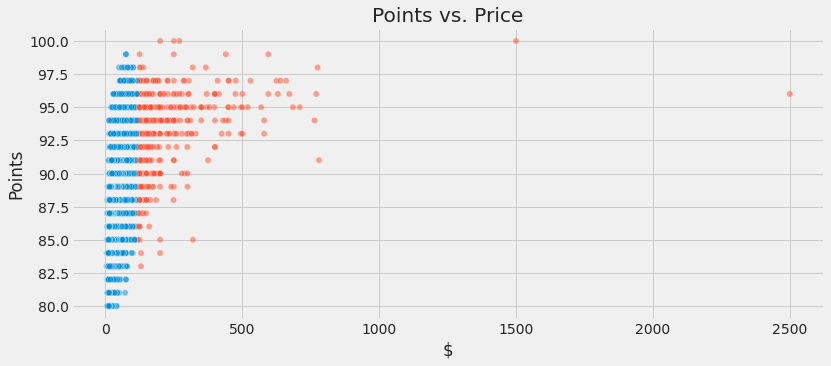

In [ ]:
def flag_outliers(df, outliers):
    flag = []
    for index in range(df.shape[0]):
        if index in outliers:
            flag.append(1)
        else:
            flag.append(0)
    return flag

#Flag outliers with 1, others with 0
wines['flag_tukey'] = flag_outliers(wines, probable_outliers_tm)

plt.figure(figsize=(12,5))
sns.scatterplot(x='Price', y='Points', data=wines, hue='flag_tukey', s=40, alpha=0.5, legend=False)
plt.title('Points vs. Price')
plt.xlabel('$')

Text(0.5, 1.0, 'Distribution of Log Price')

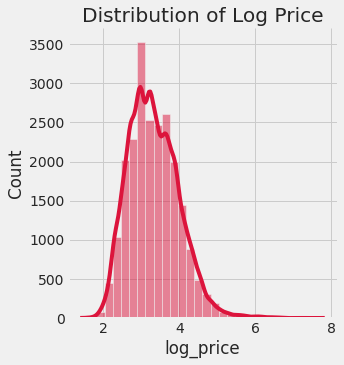

In [ ]:
# Log transform prices
log_price = np.log(wines['Price'])
wines['log_price'] = log_price

# Plot distribution
sns.displot(wines['log_price'],bins=30, kde=True, color='crimson')
plt.title('Distribution of Log Price')

In [ ]:
#Calculate probable and possible outliers using log-iq method
probable_outliers_logiq, possible_outliers_logiq, outer_fence_lower_log, outer_fence_upper_log = tukeys_method(wines, 'log_price')
print('Number of probable outliers:', len(probable_outliers_logiq))
print('Number of possible outliers:', len(possible_outliers_logiq))

Number of probable outliers: 11
Number of possible outliers: 219


### Median Absolute Deviation (MAD)

MAD is a modified, more robust alternative to z-score. It replaces mean and standard deviation with median and median absolution deviation and is more robust to outliers and doesn't assume the variable is normally distributed. Outliers lie beyond the cutoff of 3. 

In [ ]:
def mad_method(df, variable):
    # Takes two parameters: dataframe & variable as string
    # Returns array of indexes that are outliers
    
    columns = df.select_dtypes(include=np.number).columns.tolist()
    median = np.median(df, axis=0)
    mad = np.abs(stats.median_absolute_deviation(df))
    threshold = 3
    outlier = []
    index=0
    for item in range(len(columns)):
        if columns[item] == variable:
            index == item
    for i, v in enumerate(df.loc[:,variable]):
        t = (v - median[index]) / mad[index]
        if t > threshold:
            outlier.append(i)
        else:
            continue
    return outlier

prices = wines[['Price']]
outlier_mad = mad_method(prices,'Price')
print('Number of outliers:', len(outlier_mad))

Number of outliers: 1985


MAD generates 1,985 outliers, more than what we found with Tukey's method. 

Text(0.5, 0, '$')

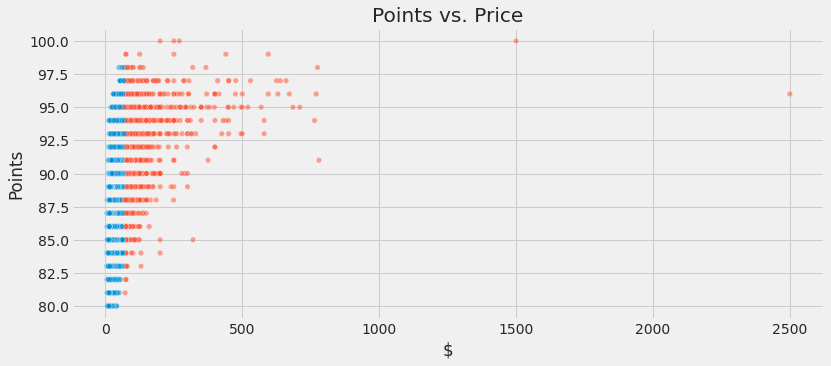

In [ ]:
#Flag outliers with 1, others with 0
wines['flag_mad'] = flag_outliers(wines, outlier_mad)

plt.figure(figsize=(12,5))
sns.scatterplot(x='Price', y='Points', data=wines, hue='flag_mad', s=30, alpha=0.5, legend=False)
plt.title('Points vs. Price')
plt.xlabel('$')

## 5. Treat

### Winsorize

Winsorizing replaces all values beyond a k percentile with the k percentile value, which is less extreme than simply removing these values. Piggybacking from the tukey method, the k percentile will be set at the distribution's outer fence. 

The price variable's upper outer fence is 117, which is closest to the 97.5% (109), so let's set the upper bound for winsorization to 97.5%. For the lower bound, a price below zero doesn't make sense, so we'll set the lower bound to 0 and the data will only be right-tail winsorized.  

In [ ]:
print('Lower outer fence: ', outer_fence_lower)
print('Upper outer fence: ', outer_fence_upper)

Lower outer fence:  -58.0
Upper outer fence:  117.0


In [ ]:
percentiles = [0.90, 0.925, 0.95, 0.975, 0.99, 0.999]
for percentile in percentiles:
  print('{}% quantile: {}'.format(percentile*100, wines['Price'].quantile(percentile)))

90.0% quantile: 65.0
92.5% quantile: 75.0
95.0% quantile: 85.0
97.5% quantile: 109.0
99.0% quantile: 160.0
99.9% quantile: 497.0800000000054


In [ ]:
# Winsorize
wines['price_winsorized'] = winsorize(wines['Price'], limits=[0, 0.025])

### Impute

Similar to howe we've imputed missing values in previous posts, we can apply it to outliers by replacing outliers with NaN and imputing these new missing values with estimates based on the remaining data. Rather than simple imputation with mean or median, which obscures valuable information held by extreme values, let's apply iterative imputation. 

In sklearn's IterativeImputer, the outlier becomes a dependent variable in a prediciton model and is predicted based on remaining non-missing non-outlier values. The default estimator is regularized linear regression BayesianRidge. Let's impute both tukey's probable outliers and MAD outliers. 


In [ ]:
# Replace probable outlier indexes from tukey method with nan
tukey_impute = wines[['Price']]
tukey_impute.iloc[probable_outliers_tm,:] = np.nan

# Call imputer to impute nans 
imputer = IterativeImputer(estimator=BayesianRidge(), # BayesianRidge is default estimator 
                           n_nearest_features=None,
                           imputation_order='ascending')
                           
# Fit imputer and transform                          
imputer.fit(tukey_impute)
tukey_impute_tf = imputer.transform(tukey_impute)
tukey_impute = pd.DataFrame(tukey_impute_tf, columns=['price_tukey_impute'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Distribution of Price Imputation')

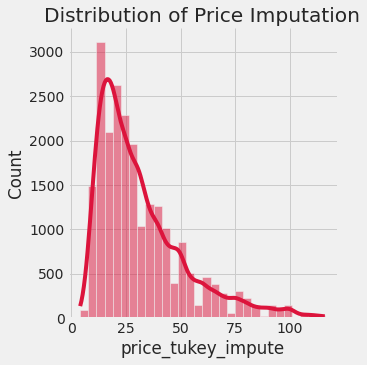

In [ ]:
# Plot distribution
sns.displot(tukey_impute['price_tukey_impute'],bins=30, kde=True, color='crimson')
plt.title('Distribution of Price Imputation')

The price distribution is less skewed than before. 

In [ ]:
# Replace probable outlier indexes from tukey method with nan
mad_impute = wines[['Price']]
mad_impute.iloc[outlier_mad,:] = np.nan

# Call imputer to impute nans 
imputer = IterativeImputer(estimator=BayesianRidge(), # BayesianRidge is default estimator 
                           n_nearest_features=None,
                           imputation_order='random')
                           
# Fit imputer and transform                          
imputer.fit(mad_impute)
mad_impute_tf = imputer.transform(mad_impute)
mad_impute = pd.DataFrame(mad_impute_tf, columns=['price_mad_impute'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Distribution of Price Imputation')

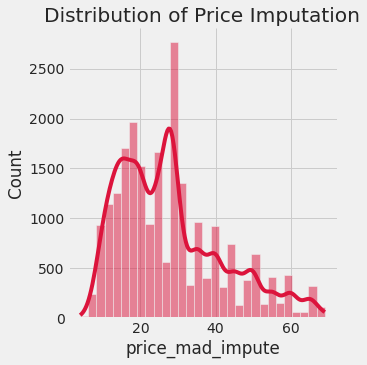

In [ ]:
# Plot distribution
sns.displot(mad_impute['price_mad_impute'],bins=30, kde=True, color='crimson')
plt.title('Distribution of Price Imputation')

In [ ]:
wines = pd.concat([wines, tukey_impute, mad_impute], axis=1)
wines.drop(['flag_tukey', 'flag_mad'], axis=1, inplace=True)
wines.describe()

,Vintage,Points,Price,Value,log_price,price_winsorized,price_tukey_impute,price_mad_impute
count,22585.000000,22585.000000,22585.000000,22585.000000,22585.000000,22585.000000,22585.000000,22585.000000
mean,2010.639982,88.448085,35.585787,3.832346,3.317956,33.364667,31.687624,27.847621
std,4.223298,3.061576,41.356674,2.209974,0.656542,22.939717,20.006363,13.841064
min,1821.000000,80.000000,4.000000,0.038400,1.386294,4.000000,4.000000,4.000000
25%,2009.000000,86.000000,17.000000,2.116279,2.833213,17.000000,17.000000,17.000000
50%,2011.000000,88.000000,25.000000,3.440000,3.218876,25.000000,25.000000,25.000000
75%,2013.000000,91.000000,42.000000,5.117647,3.737670,42.000000,40.000000,35.000000
max,2016.000000,100.000000,2500.000000,21.000000,7.824046,109.000000,116.000000,69.000000


As expected, the treated prices all have lower mean and max than the original price. The imputed MAD price treated the most outliers and has the lowest mean and max of \$27.85 and \$69, respectively. Imputed tukey price's mean of \$31.69 is between that of imputed MAD (\$27.85) and winsorized (\$33.36), though it has a slightly higher max than the latter. 

## References

https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-1-4ece5098b755

https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33

https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-3-dcb54abaf7b0

https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer

https://link.springer.com/chapter/10.1007/978-3-319-43742-2_14

http://www.hermanaguinis.com/ORMoutliers.pdf

https://github.com/pingyan/Anomaly-Detection/blob/master/MADtest.py

https://stackoverflow.com/questions/59678724/replace-given-columns-outliers-with-mean-of-before-and-after-rows-values-in-pa





